## 実際のトラジェクトリで調査

以下はローカルに実行する前提で書く(Colabで動かすならファイルをアップロードする)

In [8]:
# colabで動かす場合
%pip install pairlist
%pip install git+https://github.com/vitroid/boo.git
%pip install yaplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/vitroid/boo.git to /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-ob_mqf_b
  Running command git clone --filter=blob:none --quiet https://github.com/vitroid/boo.git /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-req-build-ob_mqf_b
  Resolved https://github.com/vitroid/boo.git to commit ee0c718a7bf73c593fd8bc30f2150ec322541d3b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for boo: filename=boo-0.1-py3-none-any.whl size=2066 sha256=8f4c7869b94d86e922df4bbfbe28d15727749212f8d931ada092f4fa4e1cb46f
  Stored in directory: /private/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/pip-ephem-wheel-cache-hvi1x1u9/wheels/4f/02/aa/0cec2e785b8c7b70e573f3a

In [21]:
from read_gro3 import read_gro
import numpy as np

with open("testcase/MethaneAR333-0.gro") as f:
    gros = [gro for gro in read_gro(f)]

# 最終フレームだけで十分。
gro = gros[-1]

# cell matrix
cellMatrix = gro["cell"]

# inverse of the cell matrix
celli = np.linalg.inv(cellMatrix)

# pickup positions of carbon atoms, in the fractional coordinate
carbons = gro["position"][gro["atom"] == "C"] @ celli
carbons.shape

(567, 3)

とりあえず、原子間距離をみつもる。短距離のRDFを作る。

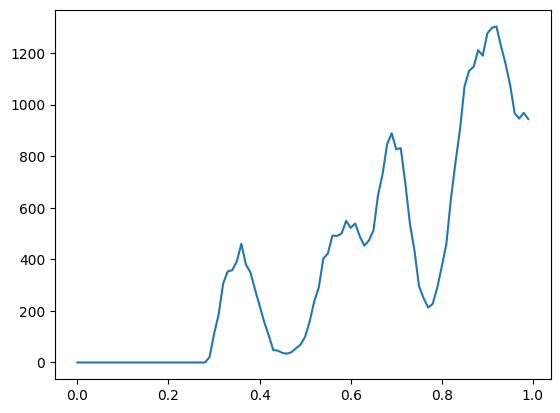

In [22]:
import pairlist as pl
import numpy as np
import matplotlib.pyplot as plt

# make the histogram of the distances of pairs within 1 nm.
H = np.histogram(
    [d for _, _, d in pl.pairs_iter(carbons, 1.0, cellMatrix)], range=(0, 1.0), bins=100
)
plt.plot(H[1][:-1], H[0])

第一隣接は0.45 nmぐらいまでか。

各原子について、0.45 nm以内にある隣接分子との相対座標ベクトルを作る。(規格化しておく)

In [27]:
import networkx as nx

# make the adjacency matrix within 0.5 nm
r_cutoff=0.45 # nm
g = nx.Graph([(i, j) for i, j in pl.pairs_iter(carbons, r_cutoff, cellMatrix, distance=False)])

neighbors = dict()

for node in g:
    # vectors to the neighbor carbons
    vectors = carbons[g[node]] - carbons[node]

    # PBC treatment
    vectors -= np.floor(vectors + 0.5)

    # normalize (length is unity)
    vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis]

    # and store.
    neighbors[node] = vectors

$q_{\{4,6,8,10,12\}}$を計算。

In [24]:
import boo

boos = np.zeros([carbons.shape[0], 5])

for node in g:
    for i, l in enumerate([4, 6, 8, 10, 12]):
        X = neighbors[node][:, 0]
        Y = neighbors[node][:, 1]
        Z = neighbors[node][:, 2]
        boos[node, i] = boo.boo(l, X, Y, Z)

boos

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51196/1192537411.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  boos[node, i] = boo.boo(l, X, Y, Z)


array([[0.07862593, 0.20461951, 0.24871769, 0.2099597 , 0.19366251],
       [0.0626715 , 0.2041181 , 0.24791272, 0.21873479, 0.20929209],
       [0.05127949, 0.18288817, 0.23107575, 0.31127748, 0.2047061 ],
       ...,
       [0.0710523 , 0.20533036, 0.2416535 , 0.25540651, 0.24406337],
       [0.06861043, 0.1507703 , 0.26228728, 0.28754627, 0.17755355],
       [0.06949953, 0.22546756, 0.17973823, 0.34347541, 0.25091673]])

In [25]:
# 扱いやすいように、見出しをつけてpandasデータフレームにする。
import pandas as pd

df_MeA = pd.DataFrame(boos, columns=["q_4", "q_6", "q_8", "q_10", "q_12"])
df_MeA

,q_4,q_6,q_8,q_10,q_12
0,0.078626,0.204620,0.248718,0.209960,0.193663
1,0.062671,0.204118,0.247913,0.218735,0.209292
2,0.051279,0.182888,0.231076,0.311277,0.204706
3,0.083433,0.183718,0.256660,0.246530,0.229902
4,0.084609,0.213424,0.264898,0.204162,0.257109
...,...,...,...,...,...
562,0.069647,0.221817,0.208371,0.286733,0.276485
563,0.055188,0.190696,0.163915,0.305983,0.210847
564,0.071052,0.205330,0.241653,0.255407,0.244063
565,0.068610,0.150770,0.262287,0.287546,0.177554


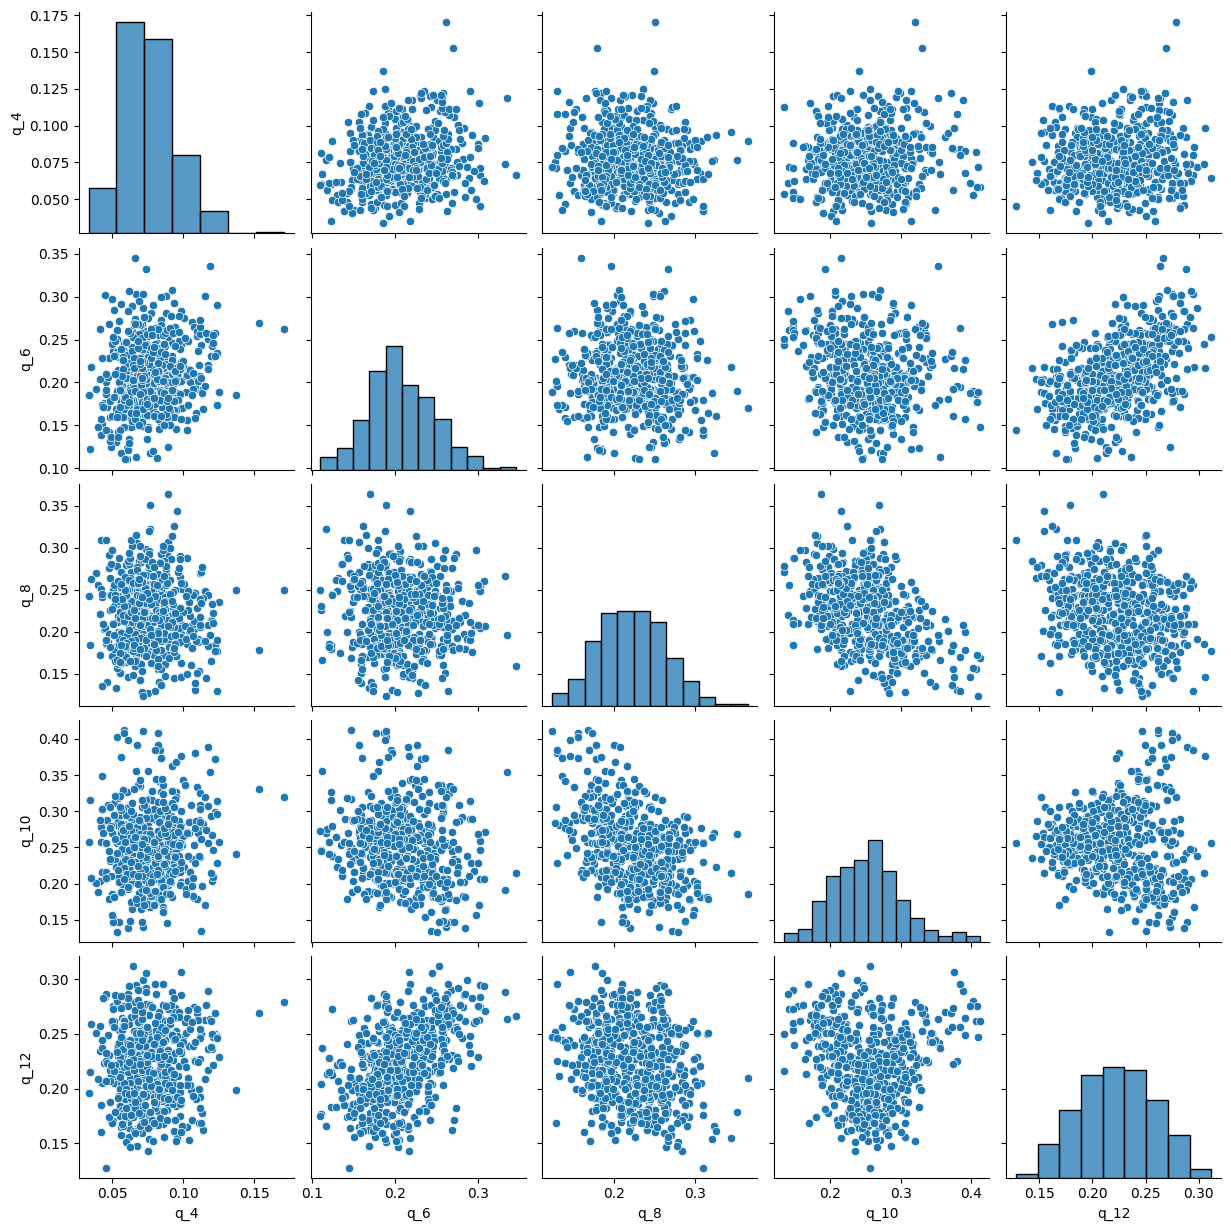

In [26]:
import seaborn as sns

sns.pairplot(df_MeA, diag_kws=dict(bins=100, binwidth=0.02))

MeBでもやってみる。

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_51196/70926989.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  boos[node, i] = boo.boo(l, X, Y, Z)


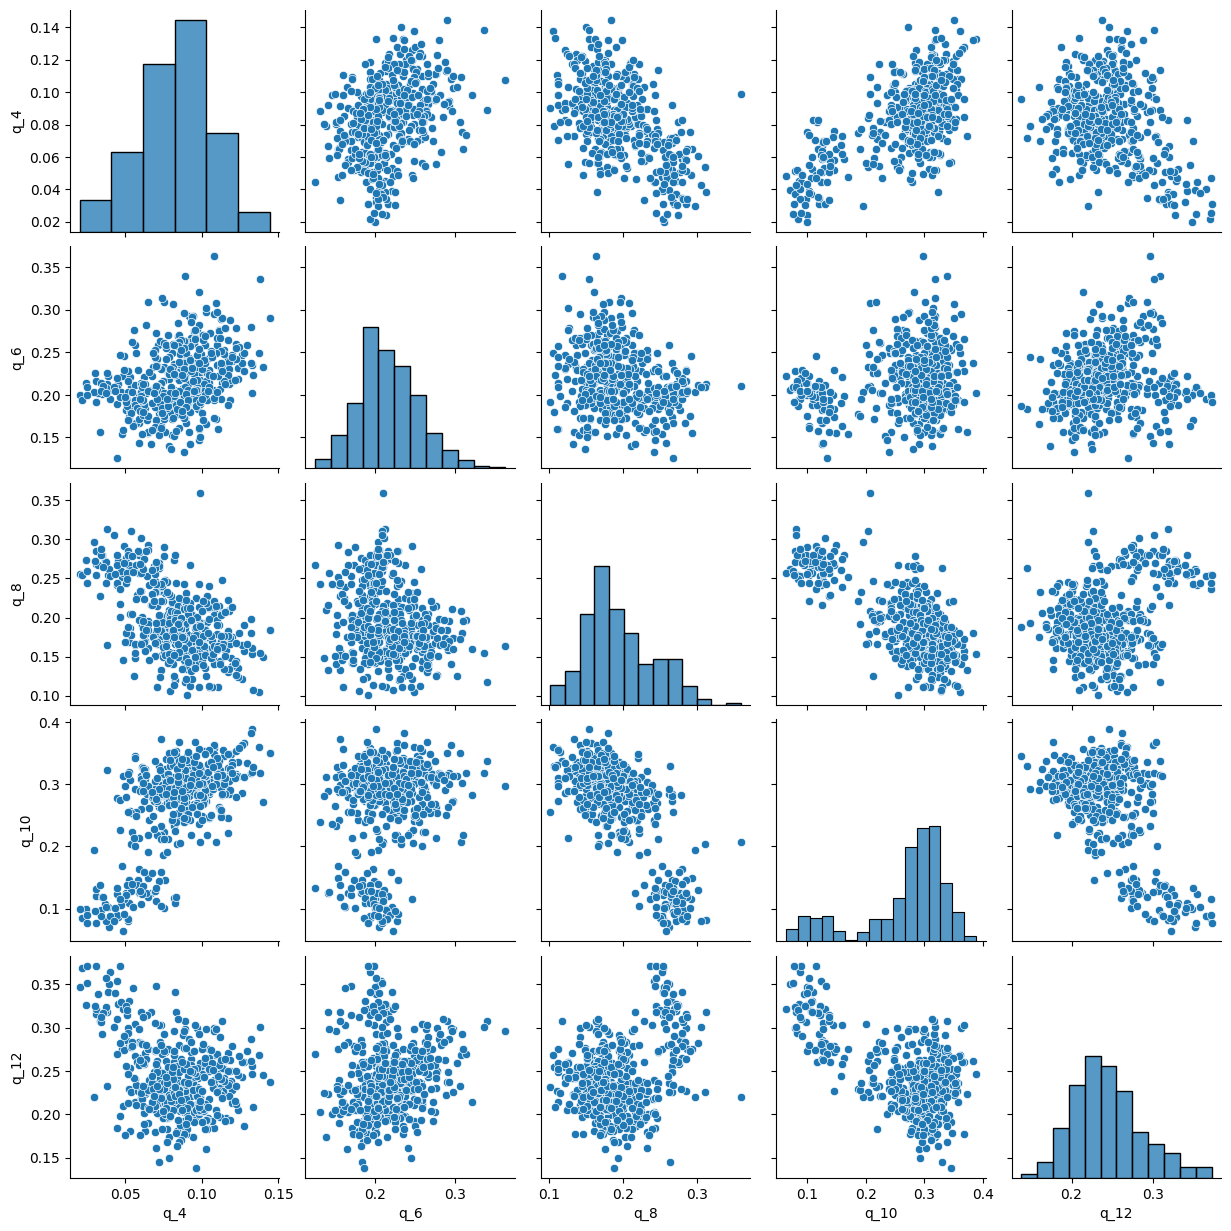

In [20]:
from read_gro3 import read_gro
import numpy as np

with open("testcase/MeB-last.gro") as f:
    gros = [gro for gro in read_gro(f)]
    
gro = gros[-1]

# cell matrix
cellMatrix = gro["cell"]

# inverse of the cell matrix
celli = np.linalg.inv(cellMatrix)

# pickup positions of carbon atoms, in the fractional coordinate
carbons = gro["position"][gro["atom"] == "C"] @ celli

import networkx as nx

# make the adjacency matrix within 0.5 nm
r_cutoff=0.45 # nm
g = nx.Graph([(i, j) for i, j in pl.pairs_iter(carbons, r_cutoff, cellMatrix, distance=False)])

neighbors = dict()

for node in g:
    # vectors to the neighbor carbons
    vectors = carbons[g[node]] - carbons[node]

    # PBC treatment
    vectors -= np.floor(vectors + 0.5)

    # normalize (length is unity)
    vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis]

    # and store.
    neighbors[node] = vectors

import boo

boos = np.zeros([carbons.shape[0], 5])

for node in g:
    for i, l in enumerate([4, 6, 8, 10, 12]):
        X = neighbors[node][:, 0]
        Y = neighbors[node][:, 1]
        Z = neighbors[node][:, 2]
        boos[node, i] = boo.boo(l, X, Y, Z)

# 扱いやすいように、見出しをつけてpandasデータフレームにする。
import pandas as pd

df_MeB = pd.DataFrame(boos, columns=["q_4", "q_6", "q_8", "q_10", "q_12"])

import seaborn as sns

sns.pairplot(df_MeB, diag_kws=dict(bins=100, binwidth=0.02))
